In [1]:
import os
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geemap
from copy import deepcopy

ModuleNotFoundError: No module named 'rasterio'

In [ ]:
import glob
imgs_all = []
imgs = []
bounds = []
t = l  = 1e10
b = r  = 0 

#profile = {'driver': 'GTiff', 'height': 100, 'width': 100, 'count': 1, 'dtype': rasterio.uint8}

def get_rst(path):
    dst_crs = 'EPSG:4326'
    #dst_crs = 'EPSG:3857'
    src = rasterio.open(path)
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open(f"temp/{path.split('/')[-1]}", 'w', **kwargs) as dst:
    #dst = rasterio.open(f"temp/{path.split('/')[-1]}",'w',**kwargs)
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                dst_nodata = 0.0,
                resampling=Resampling.nearest)
    dst = rasterio.open(f"temp/{path.split('/')[-1]}")
    os.system(f"rm -r temp/{path.split('/')[-1]}")
    return dst
                
for path in glob.glob('bd_4546QR/2013-04-23/*tif')[:100]:
    img = get_rst(path)
    x1,y1,x2,y2 = img.bounds
    print(img.bounds)
    if img.bounds.left >=88 and img.bounds.bottom >= 23 and img.bounds.right <= 93 and img.bounds.top <= 27:
        #r = np.clip(img.read(1), -1.0, 1.0)
        #g = np.clip(img.read(2), -1.0, 1.0)
        #n = np.clip(img.read(3), -1.0, 1.0)
        #ndvi = (n - g) / (n + g)
        '''
        bound = img.bounds
        _t,_l,_b,_r = bound.top, bound.left, bound.bottom, bound.right
        print('-'*10+'\n')
        flag = False
        for bound in bounds:
            scr = iou(_t,_l,_b,_r,*bound)
            if scr > 1e11 :
                print(scr)
                flag = True
        if not flag:
        '''
        #bounds.append([_t,_l,_b,_r])
        imgs += [img]
    #else:
    #    imgs_all.append(imgs)
    #    imgs = []

In [ ]:
img.bounds

In [ ]:
len(imgs)

In [2]:
#import xarray as xarr
#xarr.open_dataarray(imgs[0])
#geemap.plot_raster(imgs[0])

In [3]:
#from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import folium
# representation of the generated raster
m = folium.Map(location=[23,84], zoom_start=9)
for i in range(2):
    elevRaster = imgs[i]#rasterio.open(path)
    elevArray = elevRaster.read(1)
    
    boundList = [x for x in elevRaster.bounds]
    #print(boundlist)
    #get rid of the nan for color interpretation
    elevArray = np.clip(elevArray,-1.0,1.0)
    #plt.imshow(elevArray,cmap='terrain')
    
    rasLon = (boundList[3] + boundList[1])/2
    rasLat = (boundList[2] + boundList[0])/2
    mapCenter = [rasLon, rasLat]
    # Create a Folium map centered at a specific location
    
    
    # Add raster overlay
    image = folium.raster_layers.ImageOverlay(
        image=elevArray,
        bounds=[[boundList[1], boundList[0]], [boundList[3], boundList[2]]],
        opacity=0.6,
        interactive=True,
        cross_origin=False,
    )
    image.add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

ModuleNotFoundError: No module named 'rasterio'

In [7]:
#localtileserver
import fiona
from rasterio.merge import merge
from rasterio.rio.stack import stack
out, trans = merge(imgs, nodata = 0.0)
mat = np.array([trans.a , trans.b, trans.c, trans.d, trans.e, trans.f, 0, 0, 1]).reshape(3,3)
with fiona.open("maps/bd-boundaries/world-administrative-boundaries.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
coords = []
for coor in shapes[0].coordinates:
    coords.append(np.array(coor))

In [8]:

coords = []
for coor in shapes[0].coordinates:
    ones = np.ones(len(coor[0]))
    coords.append(np.linalg.inv(mat) @ np.concatenate([np.array(coor[0]),ones[:,None]],axis=1).T)

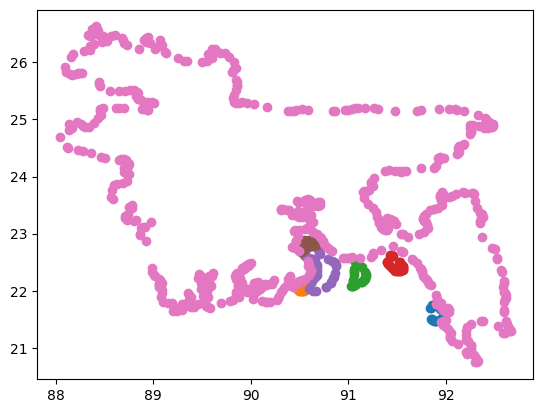

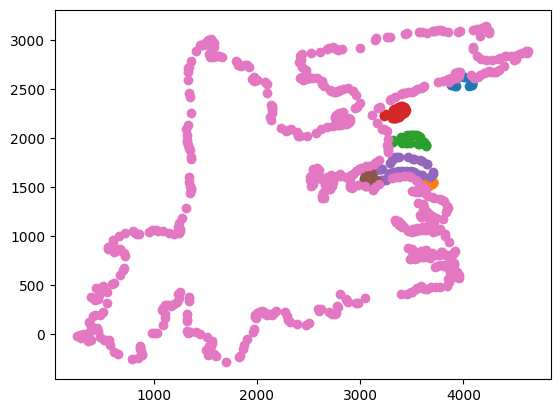

In [9]:
for coord in shapes[0].coordinates:
    coord = np.array(coord[0])
    plt.scatter(coord[:,0],coord[:,1])
plt.show()
for coord in coords:
    coord = coord.T
    plt.scatter(coord[:,1],coord[:,0])

In [10]:
bd_map = np.zeros((9000,9000),dtype=np.uint8)
for coord in coords:
    _coord = np.int32(coord).T[:,:2]
    for _coor in _coord:
       y, x = _coor
       bd_map[x-25:x+25, y-25:y+25] = 1.0
    

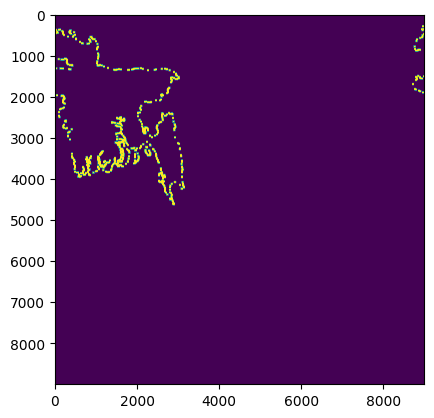

In [11]:
plt.imshow(bd_map)

In [38]:
out_image, out_transform = rasterio.mask.mask(imgs[0], shapes, crop=True)
out_meta = src.meta

AttributeError: 'list' object has no attribute 'nodata'

In [137]:
import subprocess
from osgeo import gdal
cmd = 'gdal_merge.py -ps 150 -150 -o out.tif'

In [138]:
paths = glob.glob('bd_4546QR/2013-03-22/*tif')[:10]

In [142]:
rst = gdal.Open(paths[0])

In [ ]:
rst

In [140]:
subprocess.call(cmd.split()+paths)

0...10...20...30...40...50...60...70...80...90...100 - done.


0

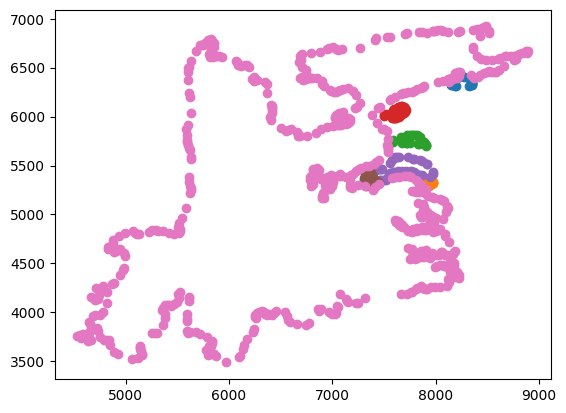

In [141]:
vrt = gdal.BuildVRT('out.vrt',paths)
gdal.Translate('out2.tif', vrt, xRes = 150, yRes = -150)
vrt = None

ERROR 5: Invalid output size: 0.588394 x 0.570796


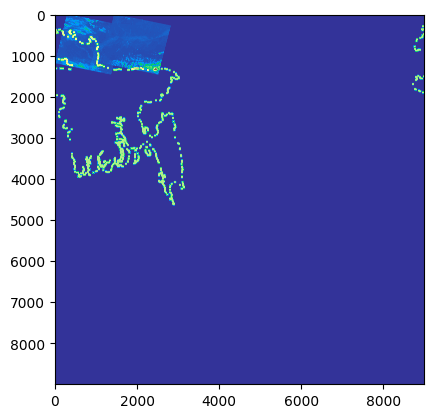

In [13]:
from matplotlib import pyplot as plt
#plt.imshow(out[0],cmap='terrain')
plt.imshow(_bd_map,cmap='terrain')

In [12]:
_bd_map = np.float32(bd_map.copy())
h,w = out[0].shape
_bd_map[:h,:w] += out[0][:9000,:9000]

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(out[0],cmap='terrain')

In [5]:
out.shape

(3, 37407, 3370)

In [30]:
from rasterio import windows as win
win.get_data_window(imgs[0])

AttributeError: 'DatasetReader' object has no attribute 'ndim'

In [55]:
out.shape

(3, 2302, 1518)

In [1]:
from osgeo import gdal

In [4]:
import glob
for path in glob.glob('45R_100/*tif')[:100]:
      img = gdal.Open(path)

In [6]:
img.

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7db7a0690540> >

In [10]:
from osgeo.gdal import gdal_merge

ImportError: cannot import name 'gdal_merge' from 'osgeo.gdal' (/usr/local/lib/python3.10/dist-packages/osgeo/gdal.py)

In [11]:
import osgeo

In [ ]:
osgeo.gdal.

In [2]:
import ee
import geemap
ee.Initialize()
# Load three NAIP quarter quads in the same location, different times.
naip_2004_2012 = (
    ee.ImageCollection('USDA/NAIP/DOQQ')
    .filterBounds(ee.Geometry.Point(-71.08841, 42.39823))
    .filterDate('2004-07-01', '2012-12-31')
    .select(['R', 'G', 'B'])
)

# Temporally composite the images with a maximum value function.
composite = naip_2004_2012.max()
m = geemap.Map()
m.set_center(-71.12532, 42.3712, 12)
m.add_layer(composite, {}, 'max value composite')
m

# Load four 2012 NAIP quarter quads, different locations.
naip_2012 = (
    ee.ImageCollection('USDA/NAIP/DOQQ')
    .filterBounds(
        ee.Geometry.Rectangle(-71.17965, 42.35125, -71.08824, 42.40584)
    )
    .filterDate('2012-01-01', '2012-12-31')
)



In [3]:
m

Map(center=[42.3712, -71.12532], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [ ]:
# Spatially mosaic the images in the collection and display.
mosaic = naip_2012.mosaic()
m = geemap.Map()
m.set_center(-71.12532, 42.3712, 12)
m.add_layer(mosaic, {}, 'spatial mosaic')

# Load a NAIP quarter quad, display.
naip = ee.Image('USDA/NAIP/DOQQ/m_4207148_nw_19_1_20120710')
m = geemap.Map()
m.set_center(-71.0915, 42.3443, 14)
m.add_layer(naip, {}, 'NAIP DOQQ')

# Create the NDVI and NDWI spectral indices.
ndvi = naip.normalizedDifference(['N', 'R'])
ndwi = naip.normalizedDifference(['G', 'N'])

# Create some binary images from thresholds on the indices.
# This threshold is designed to detect bare land.
bare_1 = ndvi.lt(0.2).And(ndwi.lt(0.3))
# This detects bare land with lower sensitivity. It also detects shadows.
bare_2 = ndvi.lt(0.2).And(ndwi.lt(0.8))

# Mask and mosaic visualization images. The last layer is on top.
mosaic = ee.ImageCollection([
    # NDWI > 0.5 is water. Visualize it with a blue palette.
    ndwi.updateMask(ndwi.gte(0.5)).visualize(
        min=0.5, max=1, palette=['00FFFF', '0000FF']
    ),
    # NDVI > 0.2 is vegetation. Visualize it with a green palette.
    ndvi.updateMask(ndvi.gte(0.2)).visualize(
        min=-1, max=1, palette=['FF0000', '00FF00']
    ),
    # Visualize bare areas with shadow (bare_2 but not bare_1) as gray.
    bare_2.updateMask(bare_2.And(bare_1.Not())).visualize(palette=['AAAAAA']),
    # Visualize the other bare areas as white.
    bare_1.updateMask(bare_1).visualize(palette=['FFFFFF']),
]).mosaic()
m.add_layer(mosaic, {}, 'Visualization mosaic')
m